In [1]:
import joblib
import pandas as pd
import anndata
import xarray as xr
from ALLCools.mcds.MCDS import MCDS
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.plot import *

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


## Load model

In [2]:
snmc_meta = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
clf = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/FinalPredictionModelRecipe/NeuronPrediction/SubTypeAll/Model/FinalClassifier.lib'
)

In [ ]:
features = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/FinalPredictionModelRecipe/NeuronPrediction/SubTypeAll/Model/ModelFeature.csv',
    index_col=0
)
features.head()

## Load Data

In [5]:
cell_annot = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/snm3CClustering/ClusteringRecipe/cell_tidy_data.final_annotation.msg'
)
# neuron_cell_ids = cell_annot[cell_annot['consensus_cluster_rescued_anno'] == 'Neuron'].index

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
mcds = xr.open_dataset(
    '/home/hanliu/project/mouse_rostral_brain/study/snm3CClustering/ClusteringRecipe/Adata/chrom100k_da_rate.nc'
)

In [7]:
data = mcds['chrom100k_da_rate'].load().sel(mc_type='CHN', chrom100k=features.index).to_pandas()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1849: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  3: pd.Panel}


## Predict

In [8]:
predict_proba = clf.predict_proba(data)
predict_proba = pd.DataFrame(predict_proba, columns=clf.classes_, index=data.index)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done 432 tasks      | elapsed:    0.8s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:    1.2s
[Parallel(n_jobs=40)]: Done 1072 tasks      | elapsed:    1.8s
[Parallel(n_jobs=40)]: Done 1488 tasks      | elapsed:    2.5s
[Parallel(n_jobs=40)]: Done 1968 tasks      | elapsed:    3.3s
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:    4.1s
[Parallel(n_jobs=40)]: Done 3120 tasks      | elapsed:    5.1s
[Parallel(n_jobs=40)]: Done 3792 tasks      | elapsed:    6.1s
[Parallel(n_jobs=40)]: Done 4528 tasks      | elapsed:    7.2s
[Parallel(n_jobs=40)]: Done 5000 out of 5000 | elapsed:    7.9s finished


In [10]:
predict_proba.to_msgpack('SubType.pred_proba.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [11]:
sub_to_major_map = snmc_meta.set_index('SubType')['MajorType'].to_dict()
sub_to_cc_map = snmc_meta.set_index('SubType')['CellClass'].to_dict()

pred_df = pd.DataFrame(predict_proba.idxmax(axis=1))
pred_df.columns = ['SubType']
pred_df['MajorType'] = pred_df['SubType'].map(sub_to_major_map)
pred_df['CellClass'] = pred_df['SubType'].map(sub_to_cc_map)

In [12]:
pred_df['MajorType'].value_counts()

DG           1933
ODC           767
CA1           686
MGC           336
ASC           211
CA3           206
CGE-Vip       136
MGE-Sst       126
ANP           107
OPC           107
OLF            93
Unc5c          86
Gfra1          80
CA3-St18       68
DG-po          67
PAL-Inh        67
VLMC           62
EC             49
NP-L6          36
OLF-Exc        32
PC             28
IG-CA2         27
MGE-Pvalb      19
CGE-Lamp5      17
D1L-Fstl4      10
IT-L23          7
CT-L6           6
Chd7            6
IT-L5           4
VLMC-Pia        4
L6b             4
LSX-Inh         3
PT-L5           3
CLA             2
Foxp2           2
D1L-PAL         1
Name: MajorType, dtype: int64

In [13]:
pred_df.to_msgpack('snm3C.pred_label.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [20]:
cell_annot_with_label = pd.concat([cell_annot, pred_df], axis=1, sort=True)

In [22]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()


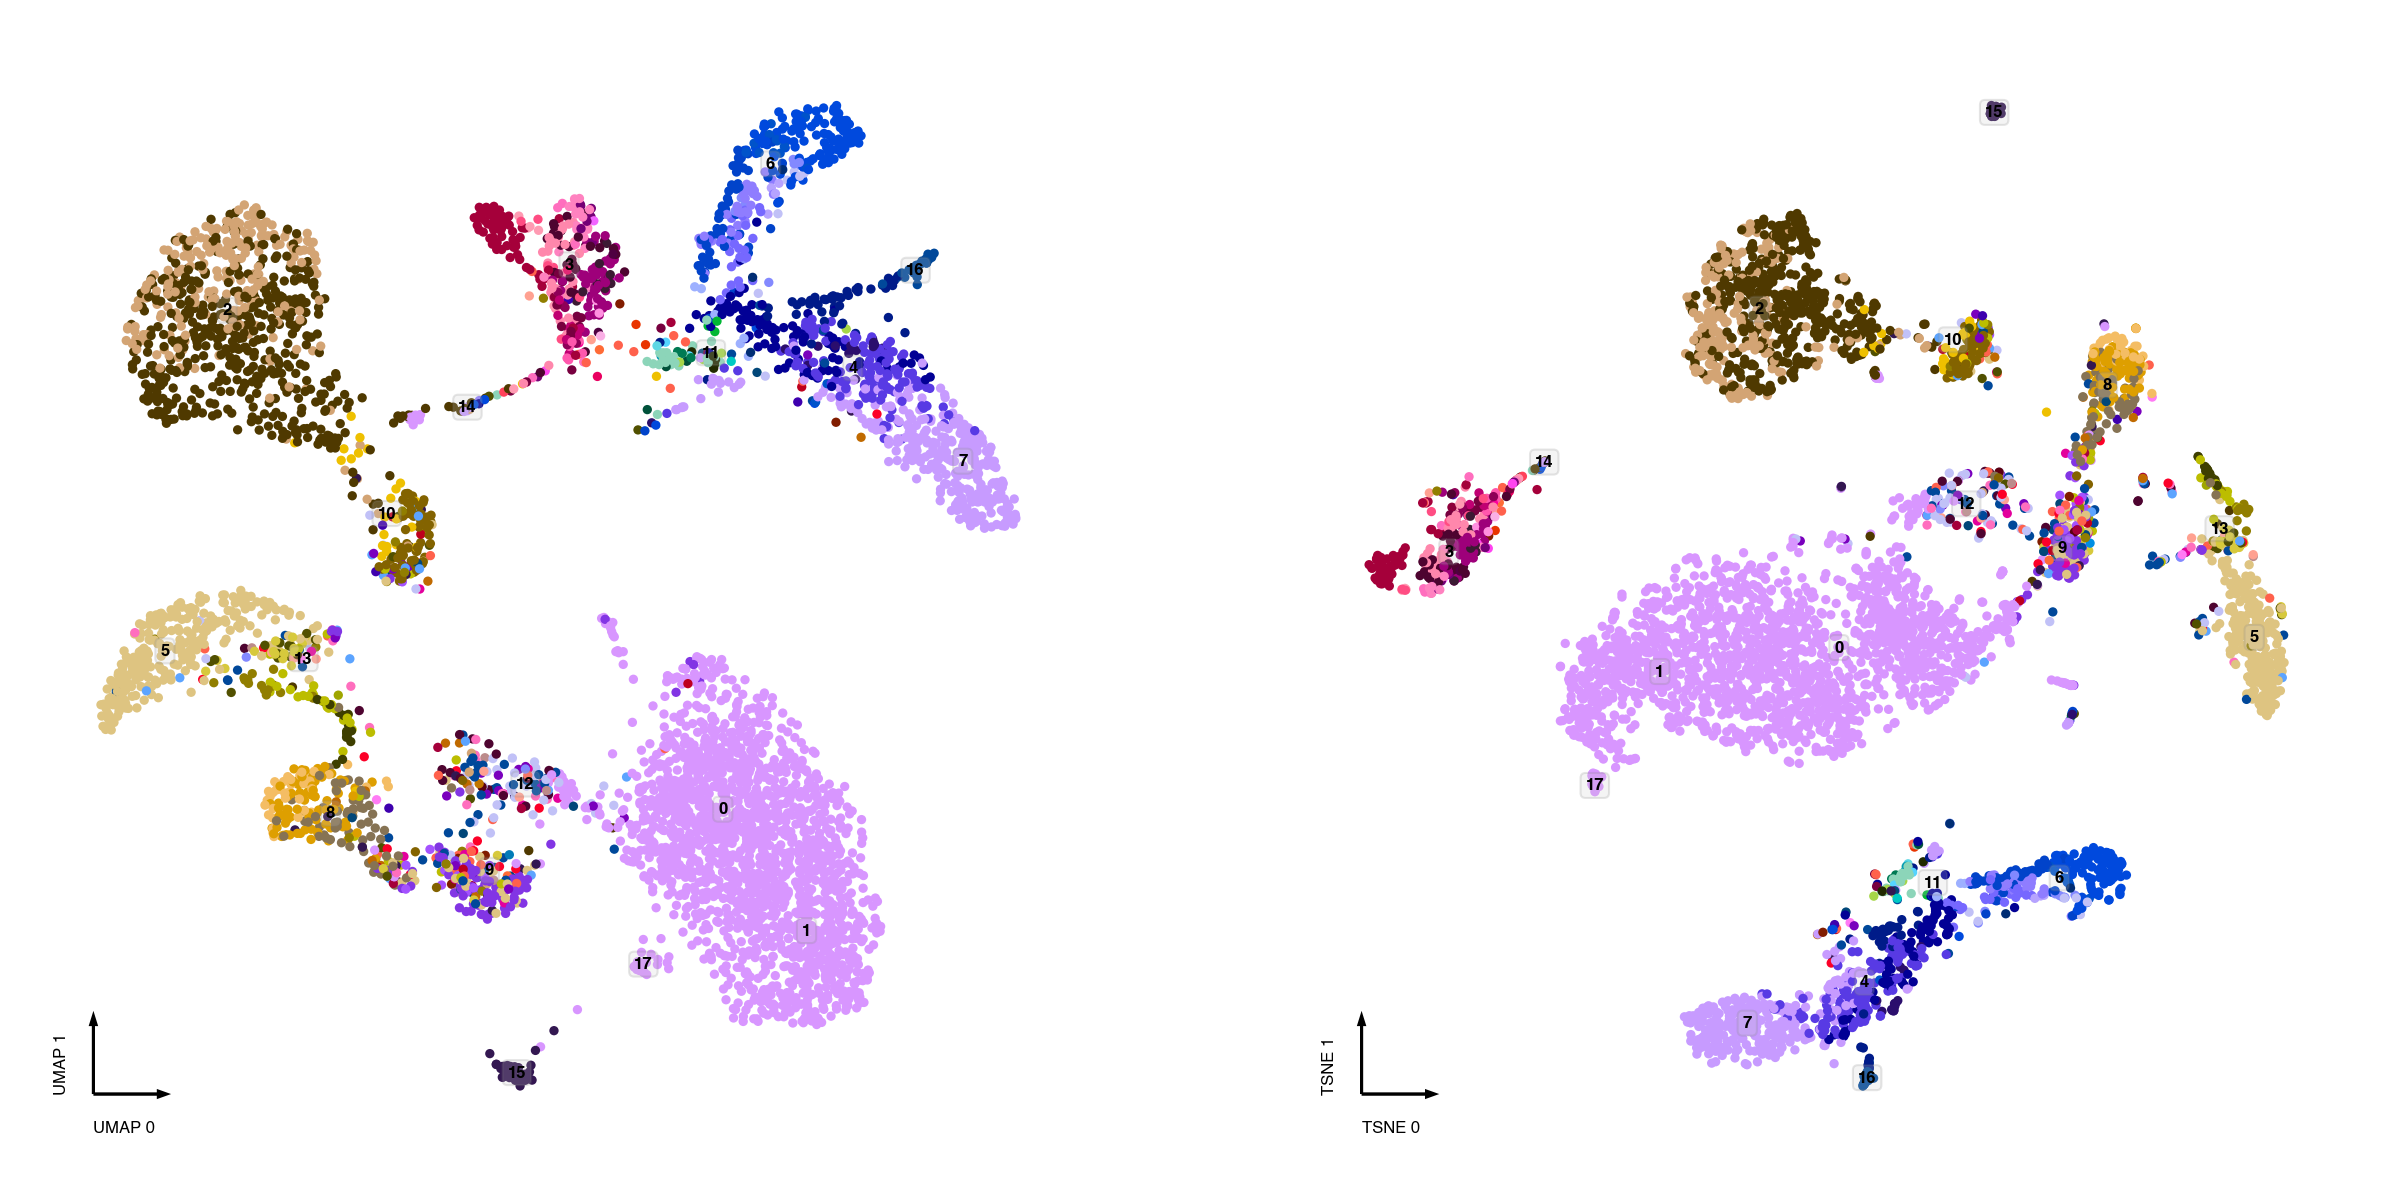

In [25]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, dpi=300)
categorical_scatter(data=cell_annot_with_label,
                    coord_base='umap',
                    ax=ax1,
                    hue='SubType',
                    palette=sub_type_palette,
                    text_anno='leiden')
categorical_scatter(data=cell_annot_with_label,
                    coord_base='tsne',
                    ax=ax2,
                    hue='SubType',
                    palette=sub_type_palette,
                    text_anno='leiden')
pass

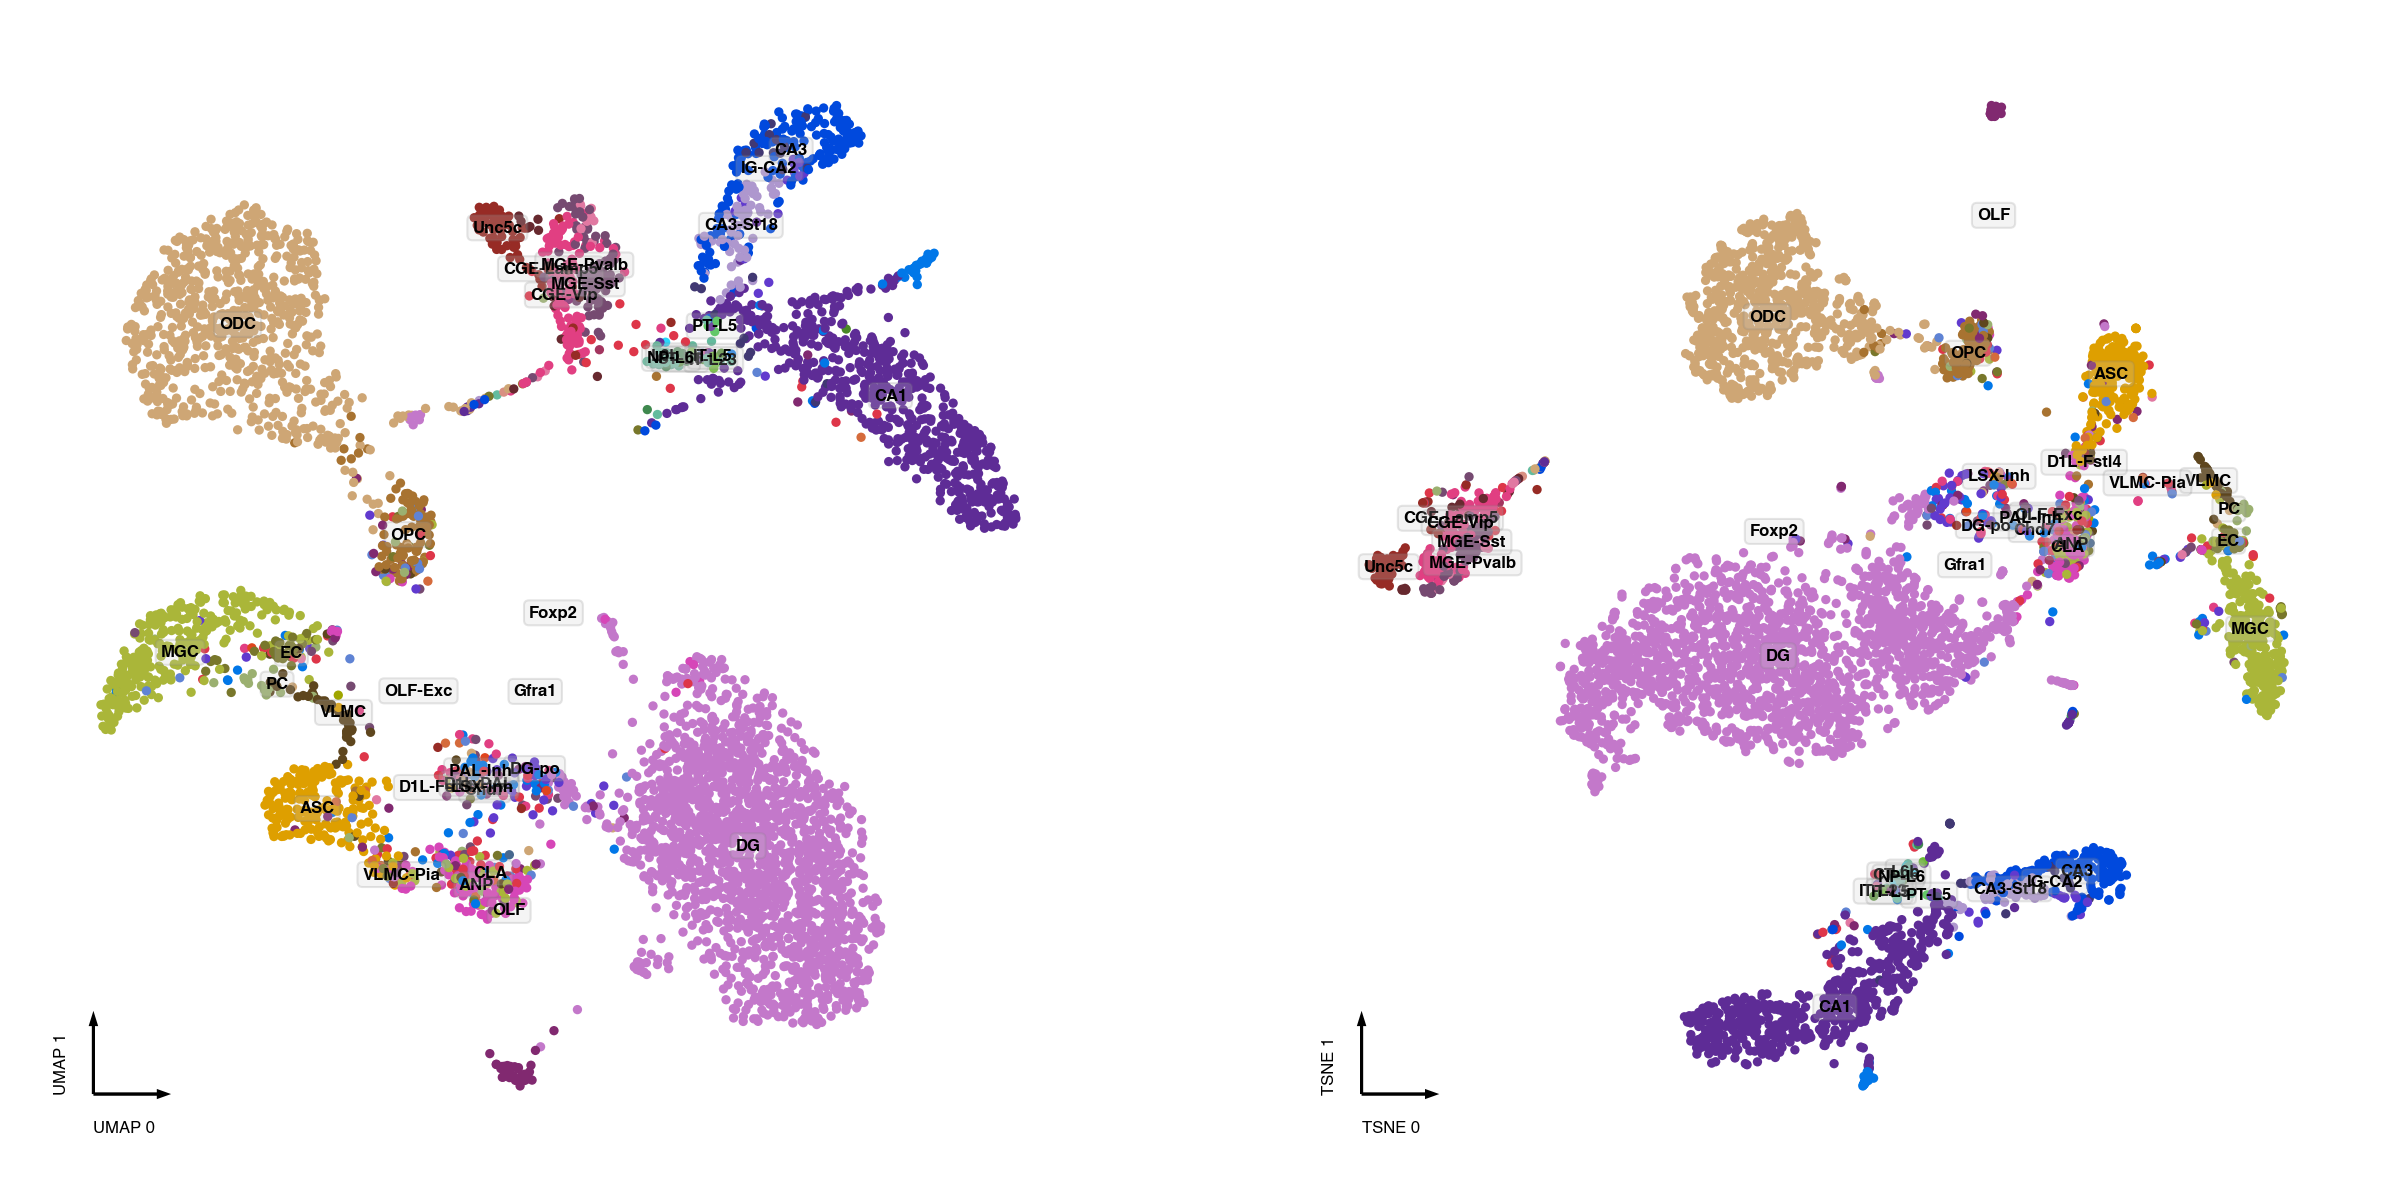

In [27]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, dpi=300)
categorical_scatter(data=cell_annot_with_label,
                    coord_base='umap',
                    ax=ax1,
                    hue='MajorType',
                    palette=major_type_palette,
                    text_anno='MajorType')
categorical_scatter(data=cell_annot_with_label,
                    coord_base='tsne',
                    ax=ax2,
                    hue='MajorType',
                    palette=major_type_palette,
                    text_anno='MajorType')
pass